К вашей компании пришел заказчик, которому нужно решение задачи анализа тональности отзывов на товары. Заказчик хочет, чтобы вы оценили возможное качество работы такого алгоритма на небольшой тестовой выборке. При этом больше никаких данных вам не предоставляется. Требуется, чтобы качество работы вашего алгоритма (по accuracy) было строго больше 85%.

Оценка качества в этом задании реализована через контест на Kaggle Inclass:

https://inclass.kaggle.com/c/product-reviews-sentiment-analysis

Вам предстоит посмотреть на предоставленные заказчиком отзывы, собрать похожие отзывы в качестве обучающей выборки, и поэкспериментировать с постановкой задачи (разметкой вашей выборки на позитивные и негативные примеры) так, чтобы результат на примерах заказчика был по возможности получше.

Обратите внимание, что заказчик предоставил всего 100 примеров в качестве тестовой выборки - ситуация, когда размеченных данных почти нет - вообще очень частая в индустриальном анализе данных. Конечно, эти отзывы можно было бы идеально разметить вручную и получить максимальное качество, но вы сами не заинтересованы в таком подходе, т.к. потом придется и на всех новых примерах демонстрировать заказчику идеальную работу, что, конечно, вряд ли будет по силам алгоритму. В любом случае рано или поздно алгоритм придется разрабатывать, поэтому попытки "сжульничать" и не делать никакой модели не одобряются.

In [2]:
import time 
import requests
from bs4 import BeautifulSoup
import numpy as np
import csv
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import nltk
import codecs

## Получение обучающей выборки

Для формирования обучающей выборки были в ручную отобраны несколько устаревших моделей телефонов с наибольшим количеством отзывов на areviews.ru.

Распарсим страницу с отзывами и сохраним результат в csv файл. Преимущества и недостатки считаются отдельными положительными и отрицательными отзывами соответсвенно. Комментарии для отзывов с рейтингом 4 и 5 отнесены к положительным отзывам, с рейтингом ниже к отрицательным.

In [67]:
headers = {
    'user-agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)',
    'accept' : '*/*'
}
URL = ['http://areviews.ru/products/lg_l80_d380/reviews', 
       'http://areviews.ru/products/htc_windows_phone_8s/reviews',
       'http://areviews.ru/products/nokia_asha_200/reviews',
       'http://areviews.ru/products/htc_wildfire_s/reviews']

file = 'review.csv' 

            
def get_url(url, params=None):
    r = requests.get(url, headers = headers, params=params)
    return r


def save_file(items, path):
    with open(path, 'a', newline='') as file:
        writer = csv.writer(file, delimiter=';')
        
        for item in items:
            writer.writerow([item['label'],item['rating'],item['Отзыв']])
            

def get_content(html):
    review = [] 
    label = 0
    soup = BeautifulSoup(html, 'html.parser')
    reviews_parser = soup.find('ul', attrs={'class', 'comment_list'})
    items = reviews_parser.find_all('li')
    for item in items:
        comment_header = item.find('div', attrs={'class', 'comment_header'})
        if not comment_header:
            continue
        rating = 5 - len(comment_header.findAll('i', attrs={'class', 'empty-star'}))
        review_parts = item.findAll('p')
        for res in review_parts:
            if res.findChild('b').text == u"Достоинства:":
                r =  res.text[12:].strip().replace('\n',' ').replace('-','').replace('=','')
                label = 1
            if res.findChild('b').text == u"Недостатки:":
                r = res.text[11:].strip().replace('\n',' ').replace('-','').replace('=','')
                label = 0
            if res.findChild('b').text == u"Комментарий:":
                if rating > 3:
                    r = res.text[12:].strip().replace('\n',' ').replace('-','').replace('=','')
                    label = 1
                else:
                    r = res.text[12:].strip().replace('\n',' ').replace('-','').replace('=','')
                    label = 0
            review.append({
                'label' : label,
                'rating' : rating,
                'Отзыв' : r})
        
    return (review)
    
    
def parse():
    for url in URL:
        html = get_url(url)
        if html.status_code == 200:
            review = get_content(html.text)
            save_file(review, file)
            print(f'Получено {len(review)} отзывов')
        else:
            print ('error')
        

parse()

Получено 177 отзывов
Получено 681 отзывов
Получено 525 отзывов


UnicodeEncodeError: 'charmap' codec can't encode character '\xd7' in position 1165: character maps to <undefined>

In [3]:
train = pd.read_csv('review.csv', names=['label','rating','review'], sep=';', encoding='cp1251').dropna()
train

,label,rating,review
0,1,3,"Большой экран, приятный внешний вид."
1,0,3,Нестабилен в работе
2,0,3,Телефон неплох. Но после года использования на...
3,1,3,Яркий и красочный экран
4,0,3,Программное обеспечение
...,...,...,...
2673,1,5,"лёгкий, тонкий, хорошая камера, яркий интерфей..."
2674,0,5,малый процессор мало встроенной памяти через п...
2675,1,5,телефон то сам по себе хорош удобный не грамоз...
2676,1,5,За 4 месяца пользования аппаратом можно сделат...


## Описательный анализ данных

In [77]:
train['label'].value_counts()

1    1507
0    1170
Name: label, dtype: int64

In [88]:
train.shape

(2677, 3)

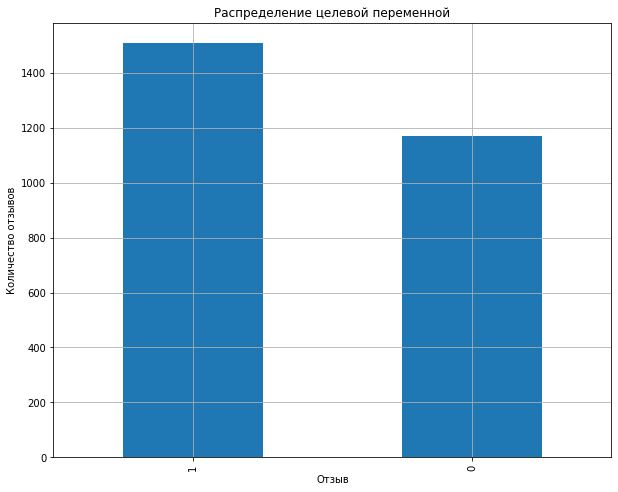

In [89]:
plt.figure(figsize=(10,8))
train['label'].value_counts().plot(kind='bar')
plt.title('Распределение целевой переменной')
plt.xlabel('Отзыв')
plt.ylabel('Количество отзывов')
plt.grid()
plt.show()

In [90]:
part_pos = train.label.sum() / train.shape[0]
print ('Доля позитивных отзывов:', part_pos)
print ('Доля негативных отзывов:', 1 - part_pos)

Доля позитивных отзывов: 0.5629435935748973
Доля негативных отзывов: 0.4370564064251027


Доли положительнных и отрицательных отзывов отличаются. Добавим в класс отрицательных еще 350 элементов.

## Анализ качества работы нескольких классификаторов

In [91]:
train = shuffle(train.append(train.iloc[list(train[train['label'] == 0].index[:350])]), random_state=1)

In [4]:
train['label'].value_counts()

1    1507
0    1170
Name: label, dtype: int64

In [6]:
def make_pipeline(vectorizer, transformer, classifier):
    return Pipeline(
            [("vectorizer", vectorizer),
            ("transformer", transformer),
            ("classifier", classifier)]
        )

In [142]:
def make_estimator(vectorizer, classifier, params_grid, scorer, data, labels):
    pipeline = make_pipeline(vectorizer(), TfidfTransformer(), classifier(max_iter=7000, random_state=42))
    grid_cv = RandomizedSearchCV(pipeline, params_grid, scoring=scorer, cv=5, random_state=1, n_iter=100)
    grid_cv.fit(data, labels)
    return grid_cv

Создадим ряд моделей с использованием различных методов обработки признаков и обучения.

In [141]:
%%time
for vectorizer in [CountVectorizer, TfidfVectorizer]:
    for classifier in [LogisticRegression, LinearSVC, SGDClassifier]:
        scores = cross_val_score(make_pipeline(vectorizer(), TfidfTransformer(), classifier(random_state=42)),
                                 train.review, train.label, cv=5).mean()
        print ('Vectorizer: ', vectorizer())
        print ('Classifier: ', classifier())
        print ('CV mean: ', scores)
        print('\n')

Vectorizer:  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)
Classifier:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
CV mean:  0.888004800480048


Vectorizer:  CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1

Лучшие результаты с параметрами по умолчанию показали Tfidf + LinearSVC и CountVectorizer + LinearSVC и Tfidf + LogisticRegression.

## Определение оптимальных параметров

In [95]:
stop_words = nltk.corpus.stopwords.words('russian')

In [139]:
parameters_grid_SVC = {
    'classifier__loss' : ['hinge', 'squared_hinge'],    
    'classifier__C' : np.arange(0.8, 2, 0.5),
    'classifier__tol' : [1e-5, 1e-4, 1e-3],
    }

parameters_grid_Tfidf = {
    'vectorizer__max_df': np.arange(0.1, 1.0, 0.05),
    'vectorizer__min_df': [1, 10, 20],
    'vectorizer__stop_words': (None, stop_words),
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    }

parameters_grid_logistic = {
    'classifier__penalty' : ['l1', 'l2'],    
    'classifier__C' : np.arange(0.1, 2, 0.05),
    'classifier__tol' : [1e-5, 1e-4, 1e-3],
    
    }

parameters_grid_count = {
    'vectorizer__max_df': np.arange(0.1, 1.0, 0.05),
    'vectorizer__min_df': [1, 10, 20],
    'vectorizer__stop_words': (None, stop_words),
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]
    
}


### TfidfVectorizer + LinearSVC

In [143]:
%%time
grid_search_SVC_Tfidf = make_estimator(TfidfVectorizer, LinearSVC, 
                                    {**parameters_grid_Tfidf, **parameters_grid_SVC}, 'accuracy', train.review, train.label)
print ('Tf-idf + LinearSVC')
print ('Best score', grid_search_SVC_Tfidf.best_score_)
print ('Best parametrs', grid_search_SVC_Tfidf.best_params_)

Tf-idf + LinearSVC
Best score 0.9157559392302866
Best parametrs {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.1, 'classifier__tol': 0.0001, 'classifier__loss': 'hinge', 'classifier__C': 1.3}
Wall time: 3min 17s


### CountVectorizer + LinearSVC

In [138]:
%%time
grid_search_SVC_count = make_estimator(CountVectorizer, LinearSVC, 
                                    {**parameters_grid_count, **parameters_grid_SVC}, 'accuracy', train.review, train.label)
print ('CountVectorizer + LinearSVC')
print ('Best score', grid_search_SVC_count.best_score_)
print ('Best parametrs', grid_search_SVC_count.best_params_)

CountVectorizer + LinearSVC
Best score 0.9131118566402096
Best parametrs {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 3), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.1, 'classifier__tol': 0.001, 'classifier__loss': 'hinge', 'classifier__C': 1.8}
Wall time: 3min 15s


### TfidfVectori + LogisticRegression

In [117]:
%%time
pipeline_log = make_pipeline(CountVectorizer(), TfidfTransformer(), LogisticRegression(solver='liblinear'))
grid_cv = RandomizedSearchCV(pipeline_log, {**parameters_grid_Tfidf, **parameters_grid_logistic},
                             scoring='accuracy', cv=5, random_state=1, n_iter=100)
grid_search_log_count = grid_cv.fit(train.review, train.label)

print ('CountVectorizer + LogisticRegression')
print ('Best score', grid_search_log_count.best_score_)
print ('Best parametrs', grid_search_log_count.best_params_)

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  FitFailedWarning)
C:\Users\chetv\anaconda3\lib\site-packag

CountVectorizer + LogisticRegression
Best score 0.8985789488039714
Best parametrs {'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 1, 'vectorizer__max_df': 0.2100000000000001, 'classifier__tol': 0.001, 'classifier__penalty': 'l2', 'classifier__C': 1.4000000000000006}
Wall time: 3min 39s


После определения оптимальных параметров лучший результат по метрике accuracy наблюдается у Tfidf + LinearSVC

## Предсказания модели

In [158]:
with open('test.csv', 'r') as f:
    test_text = f.read()
    soup = BeautifulSoup(test_text, 'html.parser')
    test_review = soup.find_all('review')
    test_list = [review.text.replace('\n', '') for review in test_review]

In [161]:
test = pd.DataFrame(test_list, columns=['text'])
test

,text
0,"Ужасно слабый аккумулятор, это основной минус ..."
1,ценанадежность-неубиваемостьдолго держит батар...
2,"подробнее в комментарияхК сожалению, факт поло..."
3,я любительница громкой музыки. Тише телефона у...
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех..."
...,...
95,"Нет передней камеры, внутренняя память очень м..."
96,"Звук при прослушивание музыки хороший,не глючи..."
97,Очень маленькая память забита вшитыми и соверш...
98,"Удобный корпус,стандартное меню нокиа,камера д..."


In [163]:
best = make_pipeline(TfidfVectorizer(ngram_range=(1,2), min_df=1, max_df=0.1, stop_words=None),
                   TfidfTransformer(),
                   LinearSVC(tol=0.0001, loss='hinge', C=1.3, random_state=1))
best.fit(train.review, train.label)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.1, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('transformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('c

In [165]:
test_predict = best.predict(test.text)
test_predict

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [172]:
pred_df = pd.DataFrame(test_predict, columns=['y'])
pred_df.index.name = 'Id'
pred_df.replace(0, 'neg', inplace=True)
pred_df.replace(1, 'pos', inplace=True)
pred_df.to_csv('answer.csv', sep=',')

In [173]:
pred_df

,y
Id,
0,neg
1,pos
2,neg
3,neg
4,pos
...,...
95,neg
96,pos
97,neg


Итоговый результат на kaggle - 0.98